In [1]:
import distmesh
from IPython.display import HTML
import ipywidgets
import itertools
import math
from matplotlib import pyplot, animation
from mpl_toolkits.mplot3d import Axes3D
import numpy
import sympy
%matplotlib inline

In [2]:
pyplot.rc('font', family='serif', size=16)

In [3]:
def rolling(t, A, f):
    """Return the instantaneous rolling angle.
    
    Parameters
    ----------
    t : float
        Time.
    A : float
        Rolling amplitude.
    f : float
        Frequency.
    
    Returns
    -------
    phi : float
        Rolling angle (in radians).

    """
    phi = -A * numpy.cos(2 * numpy.pi * f * t)
    return phi


def pitching(t, A, f, psi, bias=0.0):
    """Return the instantaneous pitching angle.
    
    Parameters
    ----------
    t : float
        Time.
    A : float
        Pitching amplitude.
    f : float
        Frequency.
    psi : float
        Phase difference (in radians) between pitching and rolling.
    bias : float (optional)
        Static pitching bias angle (in radians); default: 0.0.
    
    Returns
    -------
    theta : float
        Pitching angle (in radians).

    """
    theta = -A * numpy.cos(2 * numpy.pi * f * t + psi) + bias
    return theta

In [4]:
# Parameters.
c = 1.0  # chord length
AR = 1.27  # aspect ratio (AR = 1.27 --> S / c = 1)
S = math.pi * c * AR / 4  # span
A_plan = math.pi * c * S / 4  # planform area of the plate

A_phi = numpy.radians(45.0)  # rolling amplitude
print('Rolling amplitude: A_phi = {}'.format(A_phi))

A_theta = numpy.radians(45.0)  # pitching amplitude
print('Pitching amplitude: A_theta = {}'.format(A_theta))

psi = numpy.radians(90.0)  # phase difference
print('Phase difference: psi = {}'.format(psi))

theta_bias = numpy.radians(0.0)  # static pitching bias
print('Pitching bias: theta_bias = {}'.format(theta_bias))

U_inf = 1.0  # freestream velocity
R_avg = S / 2  # average rotational radius
St = 0.6  # Strouhal number
f = St * U_inf / (2 * A_phi * R_avg)  # flapping frequency
print('Flapping frequency: f = {}'.format(f))
T = 1 / f  # time period
print('Time period: T = {}'.format(T))

Re = 200.0  # Reynolds number
nu = U_inf * c / Re  # kinematic viscosity
print('Kinematic viscosity: nu = {}'.format(nu))

Rolling amplitude: A_phi = 0.7853981633974483
Pitching amplitude: A_theta = 0.7853981633974483
Phase difference: psi = 1.5707963267948966
Pitching bias: theta_bias = 0.0
Flapping frequency: f = 0.7658924117846005
Time period: T = 1.3056664155607796
Kinematic viscosity: nu = 0.005


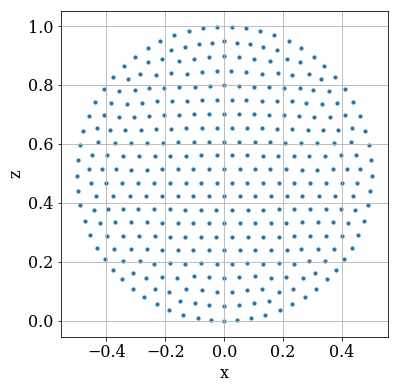

In [5]:
hook = [0.0, 0.0, 0.0]

# Create distance function.
a, b = c / 2, S / 2  # semi axes of ellipse
xc, yc, zc = hook[0], hook[1], hook[2] + b
fd = lambda p: ((p[:, 0] - xc)**2 / a**2 +
                (p[:, 1] - zc)**2 / b** 2 - 1)

# Discretize the ellipse.
ds = 0.05  # mesh resolution
bbox = (xc - a, zc - b, xc + a, zc + b)  # bounding box
p, t = distmesh.distmesh2d(fd, distmesh.huniform, ds, bbox, fig=None)

x0, z0 = p[:, 0], p[:, 1]
y0 = numpy.zeros_like(x0)

# Plot the discrete points.
fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.scatter(x0, z0, s=10)
ax.axis('scaled', adjustable='box');

In [6]:
def rotation(x, y, z,
             roll=0.0, yaw=0.0, pitch=0.0, center=[0.0, 0.0, 0.0]):
    """Rotate point.
    
    Parameters
    ----------
    x : float
        x-coordinate of point.
    y : float
        y-coordinate of point.
    z : float
        z-coordinate of point.
    roll : float (optional)
        Roll angle (in radians); default: 0.0.
    yaw : float (optional)
        Yaw angle (in radians); default: 0.0.
    pitch : float (optional)
        Pitch angle (in radians); default: 0.0.
    center : list of floats
        Coordinates of the center of rotation;
        default: [0.0, 0.0, 0.0].
    
    Returns
    -------
    xr : float
        x-coordinate of rotated point.
    yr : float
        y-coordinate of rotated point.
    zr : float
        z-coordinate of rotated point.

    """
    center = numpy.array(center)
    Rx = numpy.array([[1.0, 0.0, 0.0],
                      [0.0, math.cos(roll), math.sin(roll)],
                      [0.0, -math.sin(roll), math.cos(roll)]])
    Ry = numpy.array([[math.cos(yaw), 0.0, math.sin(yaw)],
                      [0.0, 1.0, 0.0],
                      [-math.sin(yaw), 0.0, math.cos(yaw)]])
    Rz = numpy.array([[math.cos(pitch), math.sin(pitch), 0.0],
                      [-math.sin(pitch), math.cos(pitch), 0.0],
                      [0.0, 0.0, 1.0]])
    point = numpy.array([x, y, z])
    new = Rx.dot(Ry.dot(Rz.dot(point - center))) + center
    xr, yr, zr = new
    return xr, yr, zr

vrotation = numpy.vectorize(rotation,
                            excluded=['roll', 'yaw', 'pitch',
                                      'center'])

In [7]:
sympy.init_printing(use_unicode=True)

c_a, s_a = sympy.symbols('c_theta s_theta')  # pitch
c_c, s_c = sympy.symbols('c_phi s_phi')  # roll
c_b, s_b = 1.0, 0.0

Rx = sympy.Matrix([[1, 0, 0], [0, c_c, s_c], [0, -s_c, c_c]])
Ry = sympy.Matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Rz = sympy.Matrix([[c_a, -s_a, 0], [s_a, c_a, 0], [0, 0, 1]])

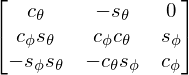

In [8]:
Rx * Ry * Rz

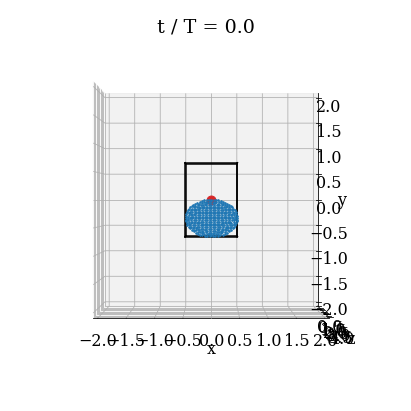

In [9]:
pyplot.rc('font', family='serif', size=16)
fig = pyplot.figure(figsize=(6.0, 6.0))
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
t = 0.0
roll = rolling(t, A_phi, f)
pitch = pitching(t, A_theta, f, psi)
x, y, z = vrotation(x0, y0, z0,
                    roll=roll, yaw=0.0, pitch=pitch,
                    center=hook)
title = ax.set_title('t / T = {}'.format(t / T))
ax.scatter(*hook, depthshade=False, c='C3', marker='o', s=80)
sc = ax.scatter(x, z, y, depthshade=False, c='C0', marker='.', s=10)
ax.set_xlim(- 2 * c, 2 * c)
ax.set_ylim(4 * c, 0.0)
ax.set_zlim(-2 * c, 2 * c)
ax.view_init(elev=0.0, azim=-90.0)
# Draw cube.
d1, d2, d3 = c, S, 2 * S * math.cos(A_phi)
r1 = [-d1 / 2, d1 / 2]
r2 = [0.0, d2]
r3 = [-d3 / 2, d3 / 2]
points = numpy.array(list(itertools.product(r1, r2, r3)))
for s, e in itertools.combinations(points, 2):
    v = numpy.sum(numpy.abs(s - e))
    if v == d1 or v == d2 or v == d3:
        ax.plot3D(*zip(s, e), color='black')

fig.tight_layout();

In [10]:
def update_figure(n, display_fig=False):
    """Update Matplotlib Figure at given time-step index.
    
    Parameters
    ----------
    n : integer
        Time-step index.

    """
    dt = T / (nt_per_period - 1)  # time-step size
    t = n * dt  # time values
    # Rotate the geometry.
    roll = rolling(t, A_phi, f)
    pitch = pitching(t, A_theta, f, psi)
    x, y, z = vrotation(x0, y0, z0,
                        roll=roll, yaw=0.0, pitch=pitch,
                        center=hook)
    # Update the figure.
    sc._offsets3d = (x, z, y)
    title.set_text('t / T = {}'.format(t / T))
    
    if display_fig:
        display(fig)

In [11]:
# Set temporal parameters.
nt_per_period = 9  # number of time steps per period
n_periods = 5  # number of periods
nt = (nt_per_period - 1) * n_periods + 1  # total number of time steps

interval_per_period = 1000.0  # animation interval per period (ms)
interval = interval_per_period / (nt_per_period - 1)

In [12]:
# Create and display the interactive widgets.
n_slider = ipywidgets.IntSlider(value=0, min=0, max=nt - 1, step=1,
                                description='Step')
w = ipywidgets.interactive(update_figure, n=n_slider,
                           display_fig=ipywidgets.fixed(True))
display(w)

interactive(children=(IntSlider(value=0, description='Step', max=40), Output()), _dom_classes=('widget-interac…

In [13]:
# Create and display Matplotlib animation.
anim = animation.FuncAnimation(fig, update_figure,
                               frames=nt, interval=interval)
HTML(anim.to_html5_video())

In [14]:
# Save the initial coordinates of the wing to a file.
filepath = 'wing.body'
with open(filepath, 'w') as infile:
    infile.write('{}\n'.format(x0.size))
with open(filepath, 'ab') as infile:
    numpy.savetxt(infile, numpy.c_[x0, y0, z0])